<div style="text-align: center; font-size: 30pt; font-weight: bold; margin: 1em 0em 1em 0em">Visualization</div>

In [1]:
import sys, os

In [2]:
sys.path.append(os.path.abspath('../autoencoders'))

In [3]:
# "Magic" commands for automatic reloading of module, perfect for prototyping
%reload_ext autoreload
%autoreload 2

import wasserstein
import proteins
import visualization

In [4]:
import matplotlib.pyplot as plt

In [5]:
# LaTeX rendering in graphs
try:
    plt.rc('text', usetex=True)
except:
    pass

plt.rc('font', family='serif')

# High resolution graphs
%config InlineBackend.figure_format = 'retina'

In [6]:
import numpy as np
import pandas as pd

import torch

In [7]:
from tqdm import tqdm

In [8]:
from scipy.stats import spearmanr

# Paths

In [9]:
ROOT = '../'

In [10]:
MODULE_PATH = ROOT + 'autoencoders/'
DATA_PATH = ROOT + 'data/'
NOTEBOOK_PATH = ROOT + 'notebooks/'
MODELS_PATH = ROOT + 'models/'
GRAPHICS_PATH = ROOT + 'graphics/'

# Loading the model

In [42]:
model = proteins.WassersteinAutoEncoder(ksi=10., hidden_dimension=10)
model.load_state_dict(torch.load(MODELS_PATH + 'wae-h=10.weights', map_location='cpu'))

In [67]:
vae = proteins.VAEProtein(hidden_dimension=2)
vae.load_state_dict(torch.load(MODELS_PATH + 'vae-protein.weights', map_location='cpu'))

wae = proteins.WAESinai2(hidden_dimension=2)
wae.load_state_dict(torch.load(MODELS_PATH + 'wae-sinai2.weights', map_location='cpu'))

In [43]:
model2 = proteins.WassersteinAutoEncoder(ksi=10., hidden_dimension=2)
model2.load_state_dict(torch.load(MODELS_PATH + 'wae.weights', map_location='cpu'))

# Dataset

In [12]:
complete_set = np.load(DATA_PATH + 'pgm-dataset.npy')

In [13]:
test_set = np.load(DATA_PATH + 'test-data.npy')
test_fitness = np.load(DATA_PATH + 'test-fitness.npy')

In [14]:
prot = visualization.Protein(complete_set[0])

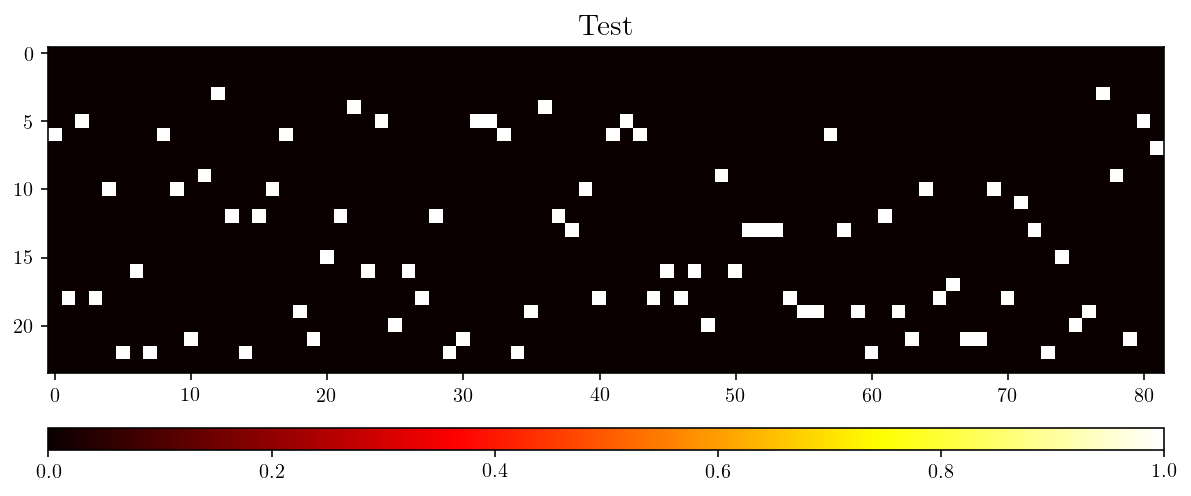

In [16]:
prot.plot_sequence(title='Test', save=GRAPHICS_PATH+'test-visualization.pdf')

Let us look at the accuracy (number of letters predicted right) and the log-probability of the sequence as output by the network. To that end, we added a `log_softmax()` method in order to use the eponymous stable loss function from `PyTorch`.

In [45]:
with torch.no_grad():
    log_reconstruction = model.log_softmax(torch.Tensor(complete_set))
    reconstruction, _ = model.forward(torch.Tensor(complete_set))

In [46]:
with torch.no_grad():
    log_reconstruction2 = model2.log_softmax(torch.Tensor(complete_set))
    reconstruction2, _ = model2.forward(torch.Tensor(complete_set))

In [47]:
reconstruction = np.array(reconstruction)
log_reconstruction = np.array(log_reconstruction)

In [48]:
reconstruction2 = np.array(reconstruction2)
log_reconstruction2 = np.array(log_reconstruction2)

# Accuracy of the reconstructions

In [49]:
accuracy = pd.DataFrame(columns=[2, 10], index=np.arange(len(complete_set)), dtype=float)

iterator = tqdm(
    enumerate(zip(
        reconstruction.reshape(-1, 24, 82), 
        complete_set.reshape(-1, 24, 82), 
        reconstruction2.reshape(-1, 24, 82)
    )), 
    ascii=True, 
    ncols=100,
    total=len(complete_set)
)

for i, (r, p, r2) in iterator:
    
    accuracy.loc[i, 2] = (r2.argmax(axis=0) == p.argmax(axis=0)).mean()
    accuracy.loc[i, 10] = (r.argmax(axis=0) == p.argmax(axis=0)).mean()

100%|#######################################################| 50000/50000 [00:15<00:00, 3196.66it/s]


In [50]:
accuracy.describe()

,2,10
count,50000.000000,50000.000000
mean,0.622569,0.679700
std,0.219195,0.221832
min,0.207317,0.195122
25%,0.426829,0.463415
50%,0.597561,0.682927
75%,0.829268,0.902439
max,1.000000,1.000000


In [51]:
accuracy.columns.names = ['hidden dim']
accuracy.index.names = ['sequence ID']

Let us save this hard-earned table:

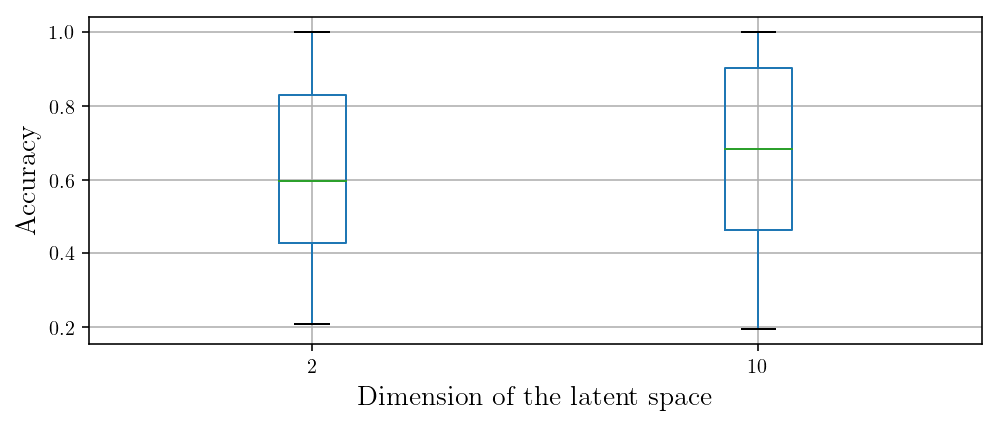

In [53]:
plt.figure(figsize=(8, 3))
accuracy.boxplot()

plt.xlabel('Dimension of the latent space', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

plt.savefig(GRAPHICS_PATH + 'accuracy-boxplots.pdf', bbox_inches='tight')

# Log-probability of the reconstructions

In [54]:
logprob = pd.DataFrame(columns=[2, 10], index=np.arange(len(complete_set)), dtype=np.longfloat)

iterator = tqdm(
    enumerate(zip(
        log_reconstruction, 
        complete_set, 
        log_reconstruction2
    )), 
    ascii=True, 
    ncols=100, 
    total=len(complete_set)
)

for i, (r, p, r2) in iterator:
    
    logprob.loc[i, 2] = r2[p == 1].sum()
    logprob.loc[i, 10] = r[p == 1].sum()

100%|#######################################################| 50000/50000 [00:14<00:00, 3409.33it/s]


In [55]:
logprob.describe()

,2,10
count,50000.000000,50000.000000
mean,-97.403748,-86.067389
std,53.150451,55.021237
min,-261.561798,-466.337158
25%,-142.929443,-136.128292
50%,-109.119221,-87.047226
75%,-48.441826,-31.131783
max,-7.847949,-4.734330


In [56]:
logprob.head()

,2,10
0,-120.229416,-98.112030
1,-130.787628,-116.137009
2,-135.576782,-119.820656
3,-104.994095,-120.569191
4,-101.122177,-87.073784


In [57]:
logprob.columns.names = ['hidden dim']
logprob.index.names = ['sequence ID']

Let us save this hard-earned table:

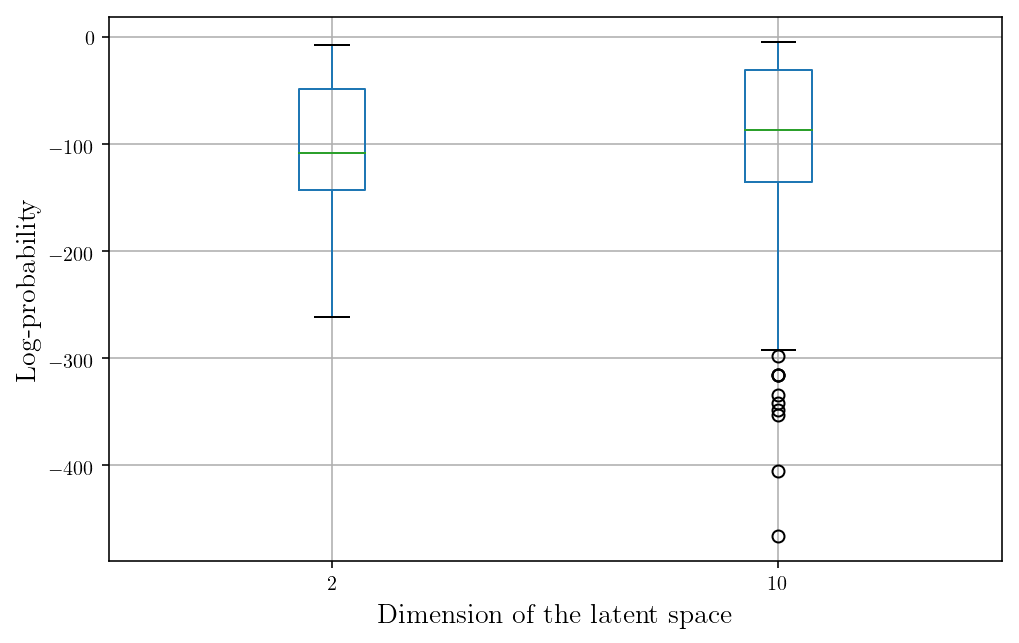

In [58]:
plt.figure(figsize=(8, 5))

logprob.boxplot()

plt.xlabel('Dimension of the latent space', fontsize=14)
plt.ylabel('Log-probability', fontsize=14)

plt.savefig(GRAPHICS_PATH + 'logprob-boxplots.pdf')

# Visualization

In [41]:
i = 27

27
Accuracy h=10 : 98.78048780487805


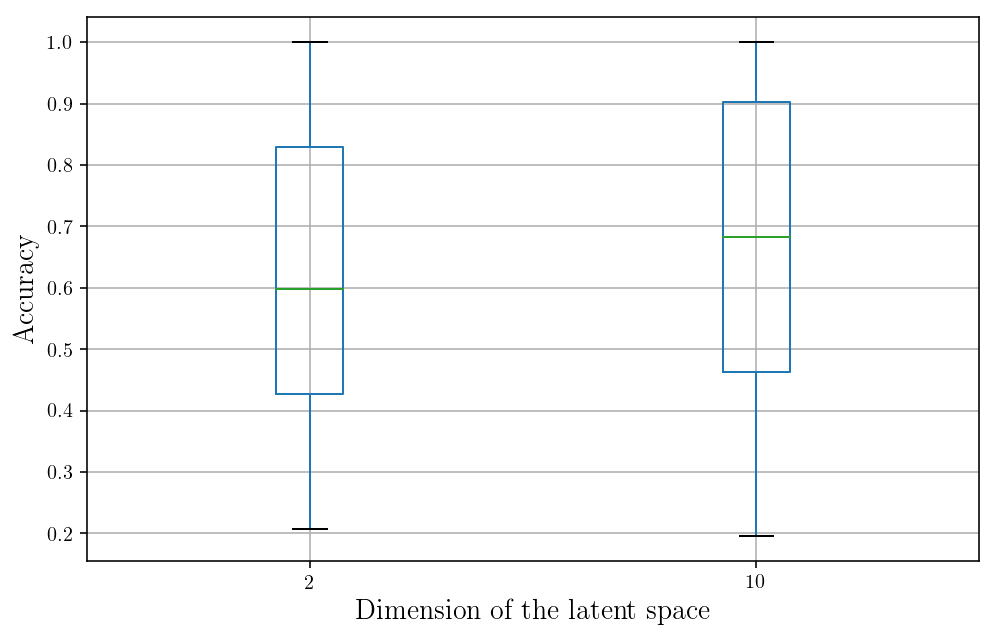

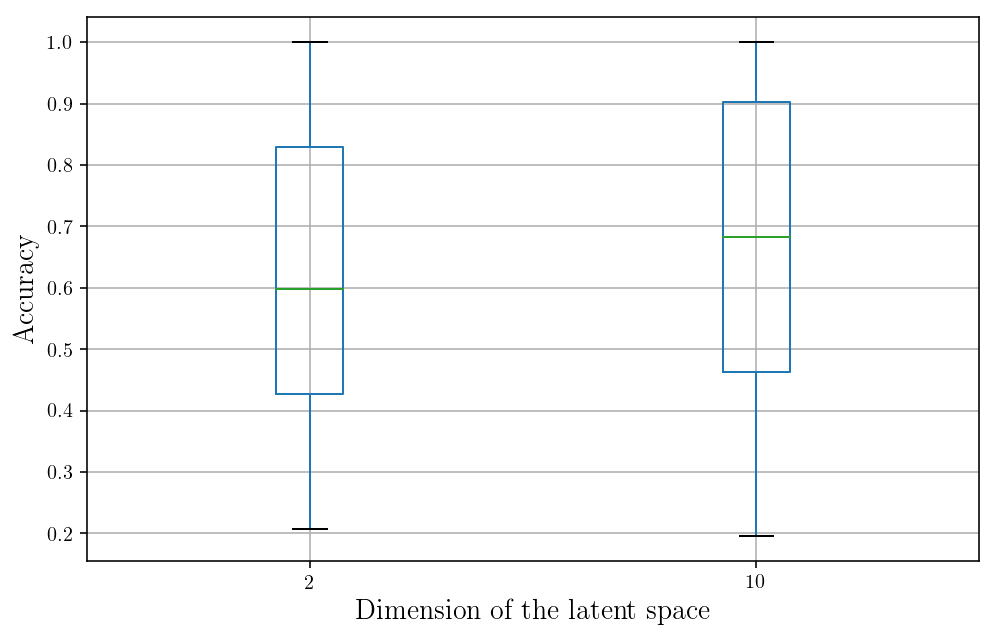

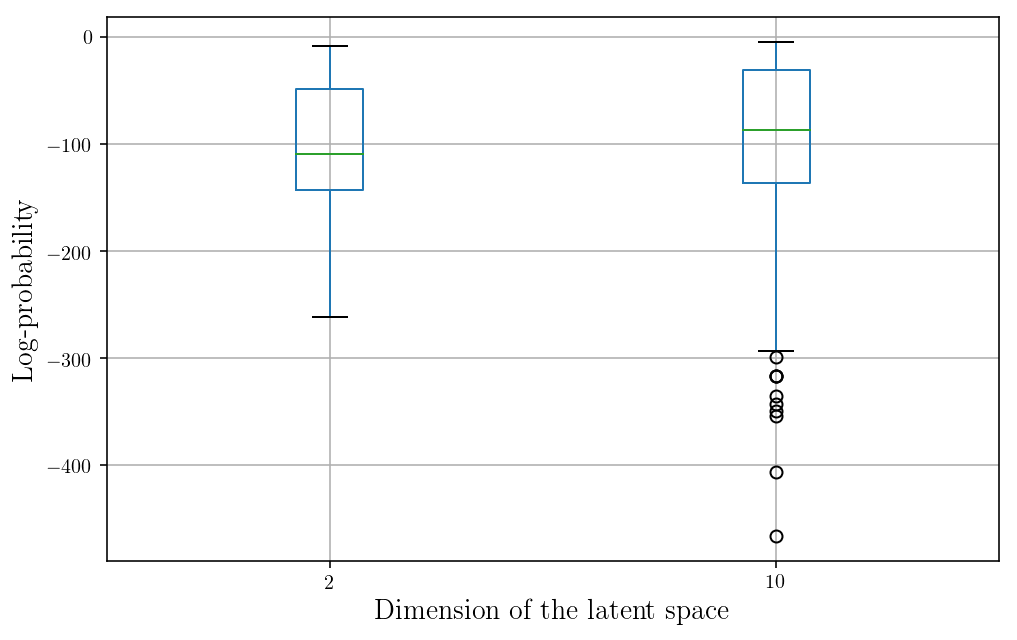

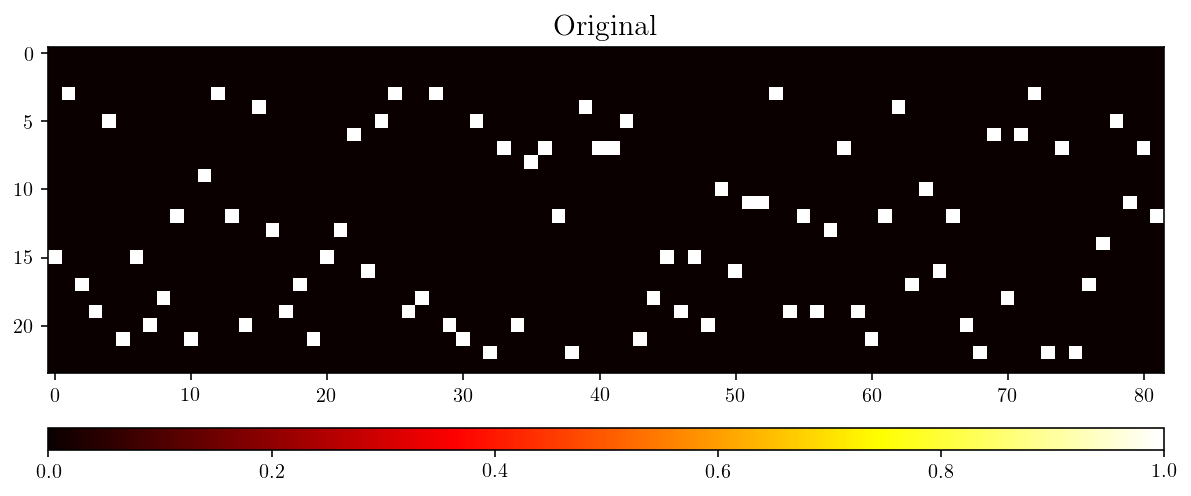

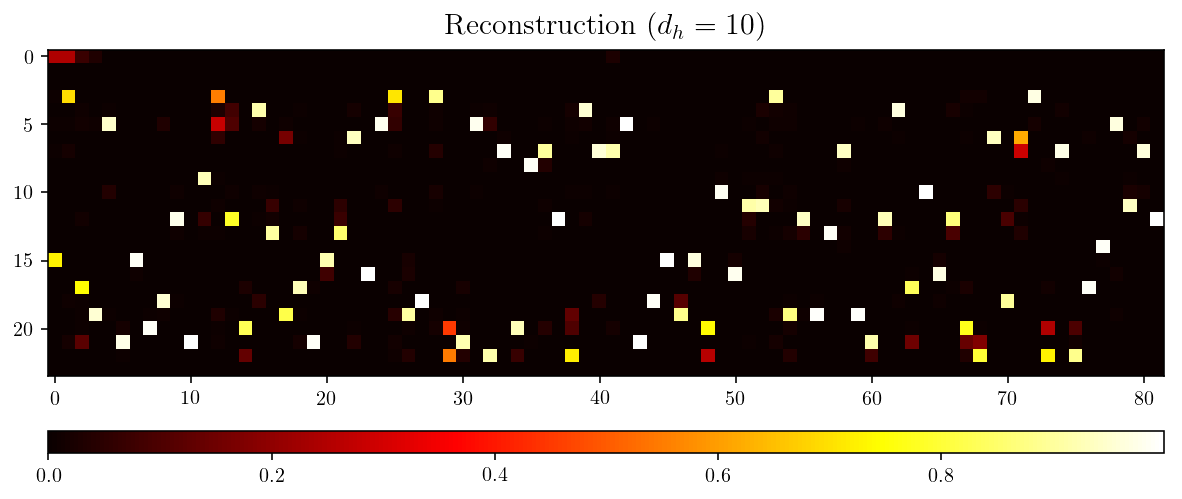

In [42]:
print(i)

prot = visualization.Protein(complete_set[i])
recon = visualization.Protein(reconstruction[i])

acc = (recon.array.argmax(axis=0) == prot.array.argmax(axis=0)).mean() * 100

print('Accuracy h=10 : {acc}'.format(acc=acc))

prot.plot_sequence(title='Original', save=GRAPHICS_PATH+'original.pdf')
recon.plot_sequence(title='Reconstruction ($d_h = 10$)', save=GRAPHICS_PATH+'reconstruction.pdf')

# Spearman correlation

In [68]:
with torch.no_grad():
    test_log_reconstruction = np.array(vae.log_softmax(torch.Tensor(test_set)))

In [69]:
test_logprob = np.array([r[t == 1].sum() for r, t in zip(test_log_reconstruction, test_set)])

In [70]:
test_logprob

array([-141.21008, -140.44994, -144.30936, ..., -144.22804, -141.23756,
       -143.79927], dtype=float32)

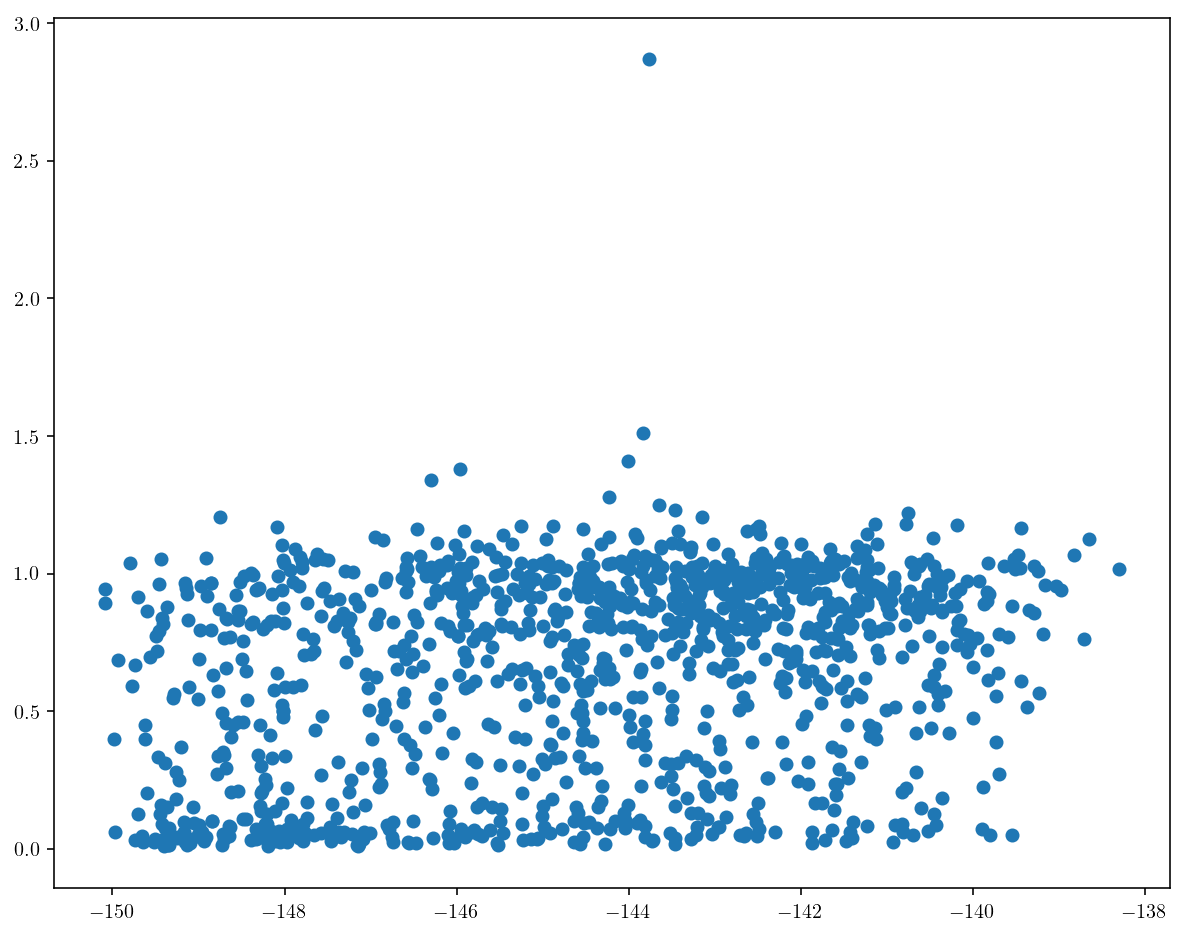

In [71]:
plt.figure(figsize=(10, 8))

plt.scatter(test_logprob, test_fitness)

In [72]:
print(spearmanr(test_logprob, test_fitness))

SpearmanrResult(correlation=0.27104820291785486, pvalue=1.961045859791292e-21)


## Latent Space Visualization

In [17]:
latent_points = model2.encode(torch.Tensor(complete_set)).detach().numpy()

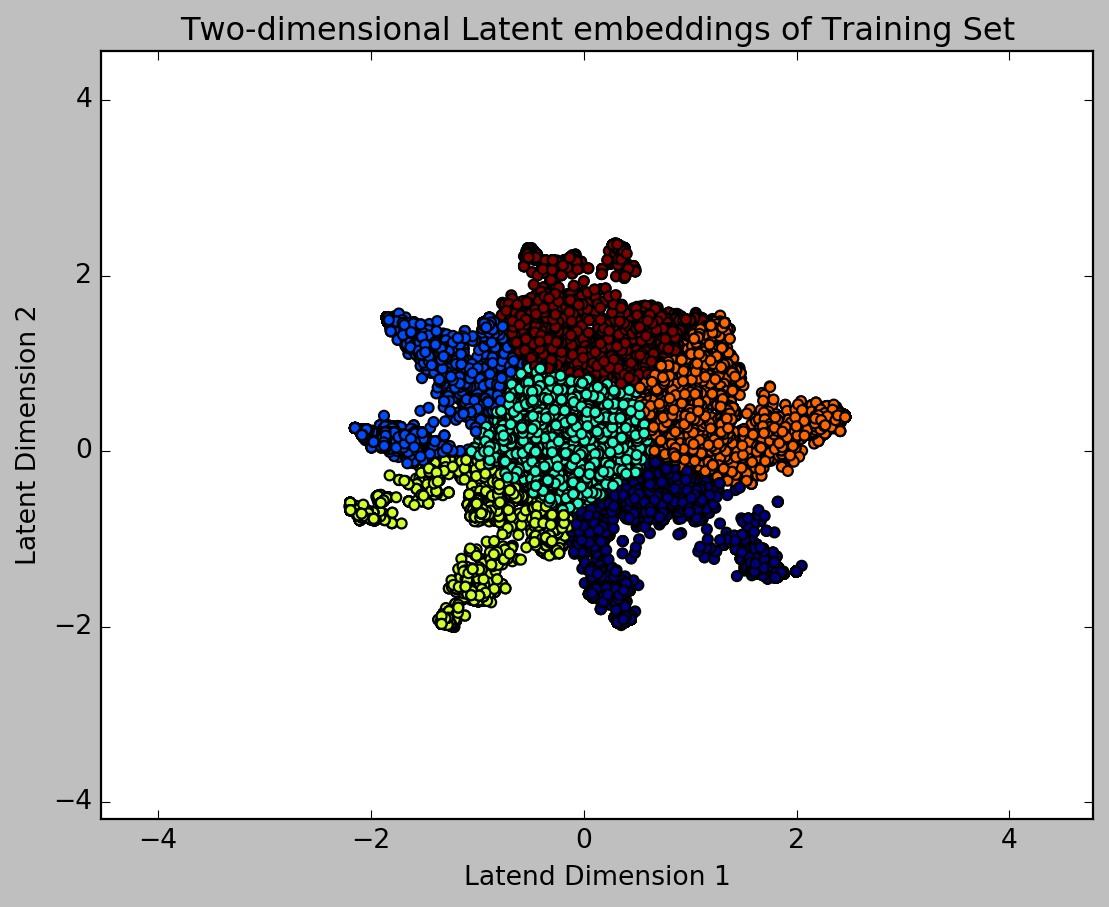

In [18]:
from sklearn.cluster import KMeans
plt.style.use('classic')
clustering = KMeans(n_clusters = 6).fit(latent_points)
ax = plt.subplot(111)
ax.margins(0.5)
ax.scatter(latent_points[:,0], latent_points[:,1], c=clustering.labels_)
ax.set_title('Two-dimensional Latent embeddings of Training Set')
ax.set_ylabel('Latent Dimension 2')
ax.set_xlabel('Latend Dimension 1')
plt.savefig(GRAPHICS_PATH + 'latent_scatter_plot.png')
plt.show()

We notice a similar branching out structure to the one obtained in the reference paper by Sam Sinai et al., but this one is much less defined and all branches are more closely muddled together towards the prior.

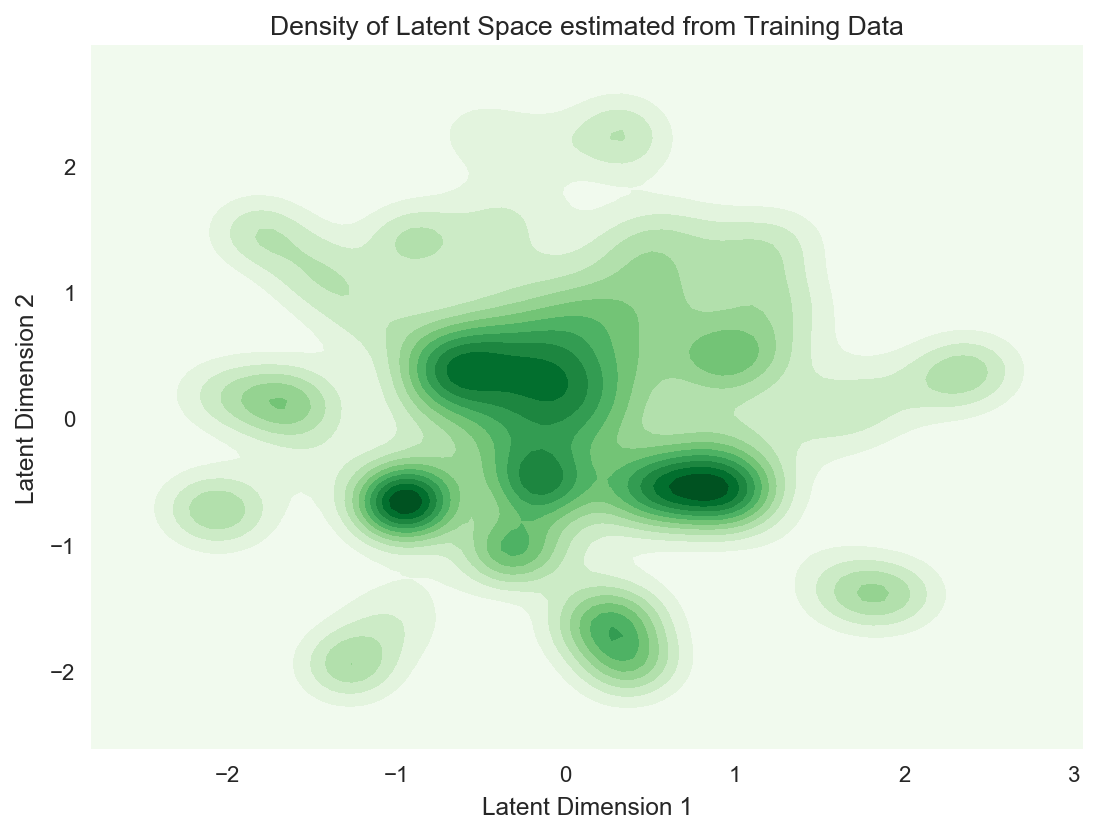

In [40]:
import seaborn as sbn

ax = plt.subplot(111)
ax = sbn.kdeplot(latent_points[:,0], latent_points[:,1], cmap="Greens", shade=True, bw = 0.2)
ax.set_title("Density of Latent Space estimated from Training Data")
ax.set_xlabel("Latent Dimension 1")
ax.set_ylabel("Latent Dimension 2")
plt.savefig(GRAPHICS_PATH + 'latent_density.png')
plt.show()